In [ ]:
!pip3 install -r requirements.txt
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 13.6 MB 5.1 MB/s 
ERROR: Operation cancelled by user

Aborted!


## Dataset: Complaints (translated)

In [ ]:
import pandas as pd
df = pd.read_csv ('translated_data.csv')
df.dropna()

,product,sub-product,issue,sub-issue,narrative,traduccion
0,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,there is incorrect information on my credit re...,hay información incorrecta en mi informe de cr...
1,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,this item showed up on my credit report .i hav...,este artículo apareció en mi informe de crédit...
2,"Credit reporting, credit repair services, or o...",Credit reporting,Unable to get your credit report or credit score,Other problem getting your report or credit score,i was applying for an apartment and kept getti...,Estaba solicitando un apartamento y me lo nega...
3,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,i just had a account hit my credit report abou...,Acabo de recibir una cuenta en mi informe de c...
4,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,the data breach with equifax caused some items...,la violación de datos con equifax provocó que ...
...,...,...,...,...,...,...
55876,Debt collection,Auto,Improper contact or sharing of info,Talked to a third party about my debt,i received over five phone calls yesterday fro...,Ayer recibí más de cinco llamadas telefónicas ...
55877,Credit card or prepaid card,General-purpose credit card or charge card,Fees or interest,Problem with fees,i opened account and chase decided to close it...,Abrí una cuenta y Chase decidió cerrarla un me...
55878,Debt collection,I do not know,Attempts to collect debt not owed,Debt was result of identity theft,i have recently pulled my credit report and fo...,Recientemente saqué mi informe de crédito y en...
55879,Debt collection,I do not know,Cont'd attempts collect debt not owed,Debt resulted from identity theft,national recovery agency appeared on my credit...,la agencia nacional de recuperación apareció e...


In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
df['product_str']= df['product']
df['product']=le.fit_transform(df['product'])
df

,product,sub-product,issue,sub-issue,narrative,traduccion,product_str
0,2,Credit reporting,Incorrect information on your report,Information belongs to someone else,there is incorrect information on my credit re...,hay información incorrecta en mi informe de cr...,"Credit reporting, credit repair services, or o..."
1,3,I do not know,Attempts to collect debt not owed,Debt is not yours,this item showed up on my credit report .i hav...,este artículo apareció en mi informe de crédit...,Debt collection
2,2,Credit reporting,Unable to get your credit report or credit score,Other problem getting your report or credit score,i was applying for an apartment and kept getti...,Estaba solicitando un apartamento y me lo nega...,"Credit reporting, credit repair services, or o..."
3,2,Credit reporting,Incorrect information on your report,Information belongs to someone else,i just had a account hit my credit report abou...,Acabo de recibir una cuenta en mi informe de c...,"Credit reporting, credit repair services, or o..."
4,2,Credit reporting,Incorrect information on your report,Information belongs to someone else,the data breach with equifax caused some items...,la violación de datos con equifax provocó que ...,"Credit reporting, credit repair services, or o..."
...,...,...,...,...,...,...,...
55876,3,Auto,Improper contact or sharing of info,Talked to a third party about my debt,i received over five phone calls yesterday fro...,Ayer recibí más de cinco llamadas telefónicas ...,Debt collection
55877,1,General-purpose credit card or charge card,Fees or interest,Problem with fees,i opened account and chase decided to close it...,Abrí una cuenta y Chase decidió cerrarla un me...,Credit card or prepaid card
55878,3,I do not know,Attempts to collect debt not owed,Debt was result of identity theft,i have recently pulled my credit report and fo...,Recientemente saqué mi informe de crédito y en...,Debt collection
55879,3,I do not know,Cont'd attempts collect debt not owed,Debt resulted from identity theft,national recovery agency appeared on my credit...,la agencia nacional de recuperación apareció e...,Debt collection


# Text Clasification
In this Notebook we preprocess data and train many models looking for classify complaints.
Previous work done: translate the dataset.

## Dataset exploration

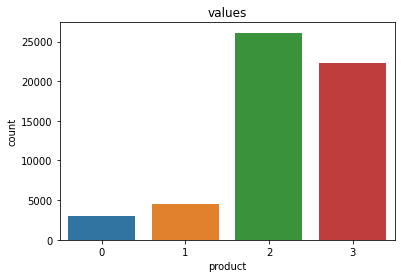

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig , ax = plt.subplots(figsize=(6,4))
sns.countplot(x='product', data=df)
plt.title("values")
plt.show()

In [ ]:
df['product_str'].unique()

array(['Credit reporting, credit repair services, or other personal consumer reports',
       'Debt collection', 'Credit card or prepaid card',
       'Checking or savings account'], dtype=object)

In [ ]:
df['product'].unique()

array([2, 3, 1, 0])

In [32]:
df['traduccion'].values

array(['hay información incorrecta en mi informe de crédito.',
       'este artículo apareció en mi informe de crédito. Nunca he tenido un contrato con ellos, nunca he recibido una factura detallada desde el primer día o un contrato de propiedad de ellos. No tengo ningún contrato firmado con ellos.',
       'Estaba solicitando un apartamento y me lo negaron porque no pueden obtener mi puntaje de crédito de Equifax ni informar porque dice que no tengo un puntaje. Me comuniqué con mis acreedores para asegurarme de que no se tratara de un problema con información incorrecta. mis acreedores informan mi crédito a equifax pero no lo publican en mi archivo de crédito ni me dan un puntaje.',
       ...,
       'Recientemente saqué mi informe de crédito y encontré cuentas que no reconocí.',
       'la agencia nacional de recuperación apareció en mis informes de crédito por una deuda que no debo. estaba en mis informes de crédito como una factura que supuestamente debía a una empresa de servicio

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

X = df[df['product'] == 0][0:3000].traduccion.values.tolist() + df[df['product'] == 1][0:3000].traduccion.values.tolist() + df[df['product'] == 2][0:3000].traduccion.values.tolist() + df[df['product'] == 3][0:3000].traduccion.values.tolist()
y = df[df['product'] == 0][0:3000]['product'].values.tolist() + df[df['product'] == 1][0:3000]['product'].values.tolist() + df[df['product'] == 2][0:3000]['product'].values.tolist() + df[df['product'] == 3][0:3000]['product'].values.tolist()
X = np.asarray(X)
y = np.asarray(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=2020)
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=2020)

Cleaning the dataset

In [ ]:
import nltk
import re
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('spanish')
                 or word in ['no']])

    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

In [29]:
print(X_train_tfidf.shape, X_val_tfidf.shape)

(8400, 261835) (3600, 261835)


In [51]:
model_name= []; f1 = []; accuracy = []; f1_score_label_1=[]; f1_score_label_2=[];  f1_score_label_3=[];  f1_score_label_4=[];

## NLP models

In [37]:
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score, classification_report,confusion_matrix
import seaborn as sns

def scores(predictions,y_val):
  a= df['product'].unique()
  print(f'Labels order: {a} ')
  results= f1_score(y_val, predictions,labels= df['product'].unique(), average = None)
  print(f'F1 Score: {results}')
  print(f"Test Set Accuracy : {accuracy_score(y_val, predictions) * 100} %\n\n")
  print(f"Classification Report : \n\n{classification_report(y_val, predictions)}")

  plt.figure(figsize = (18,8))
  sns.heatmap(confusion_matrix(y_val, predictions), annot = True, xticklabels = df['product'].unique(), yticklabels = df['product'].unique(), cmap = 'summer')
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.show() 


## Support-vector machine (SVM)

For performing linear classification, SVMs can efficiently perform a non-linear classification using what is called the kernel trick, implicitly mapping their inputs into high-dimensional feature spaces.

In [38]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

parameters = {
    "estimator__C": [1,2,4,8],
    "estimator__degree":[1, 2],
}

cv = GridSearchCV(OneVsRestClassifier(SVC()), param_grid=parameters, scoring = 'f1_micro')

cv.fit(X_train_tfidf, y_train)

print(cv.best_score_)
print(cv.best_params_)

0.8188095238095237
{'estimator__C': 2, 'estimator__degree': 1}


In [39]:
predictions = cv.best_estimator_.predict(X_val_tfidf)

Labels order: [2 3 1 0] 
F1 Score: [0.82122905 0.84517906 0.78938257 0.86358754]
Test Set Accuracy : 83.05555555555556 %


Classification Report : 

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       884
           1       0.84      0.75      0.79       916
           2       0.81      0.84      0.82       879
           3       0.86      0.83      0.85       921

    accuracy                           0.83      3600
   macro avg       0.83      0.83      0.83      3600
weighted avg       0.83      0.83      0.83      3600



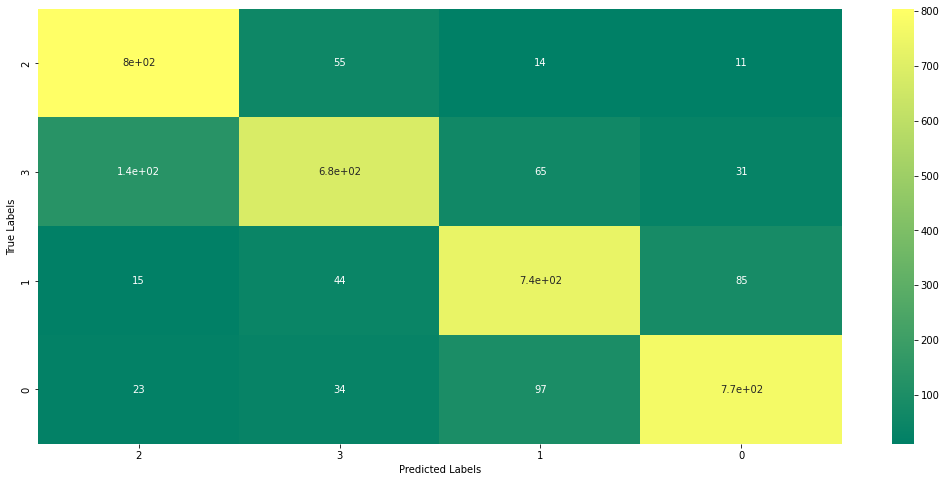

In [40]:
scores(predictions,y_val)

In [49]:
for i in range(4):
  print('Prediction:'+ str(predictions[i])+ ', True label:'  + str(y_val[i]))


Prediction:0, True label:0
Prediction:0, True label:3
Prediction:2, True label:2
Prediction:0, True label:0


In [52]:
model_name.append('Support Vector Machine')
f1.append(f1_score(y_val, predictions,average='weighted') * 100)
accuracy.append(accuracy_score(y_val, predictions) * 100)

In [53]:
a,b,c,d=f1_score(y_val, predictions,average=None)
f1_score_label_1.append(d)
f1_score_label_2.append(c) 
f1_score_label_3.append(b) 
f1_score_label_4.append(a)  

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
param_grid = { 
    'n_estimators': [100, 200, 500, 600],
    'max_depth' : [7,8, 9, 10, 11]
 #   'criterion' :['gini', 'entropy']
}
rfc=RandomForestClassifier(random_state=42)

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train_tfidf, y_train)




GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [7, 8, 9, 10, 11],
                         'n_estimators': [100, 200, 500, 600]})

In [ ]:
print(CV_rfc.best_score_)
print(CV_rfc.best_params_)

0.7867857142857143
{'max_depth': 11, 'n_estimators': 600}


In [ ]:
import sklearn.metrics
predictions = CV_rfc.best_estimator_.predict(X_val_tfidf)

f1_score(y_val, predictions, average = None) 

array([0.83572895, 0.72841051, 0.78608515, 0.82060185])

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
print(f"Test Set Accuracy : {accuracy_score(y_val, predictions) * 100} %\n\n")
print(f"Classification Report : \n\n{classification_report(y_val, predictions)}")

Test Set Accuracy : 79.5 %


Classification Report : 

              precision    recall  f1-score   support

           0       0.77      0.92      0.84       884
           1       0.85      0.64      0.73       916
           2       0.72      0.86      0.79       879
           3       0.88      0.77      0.82       921

    accuracy                           0.80      3600
   macro avg       0.80      0.80      0.79      3600
weighted avg       0.81      0.80      0.79      3600



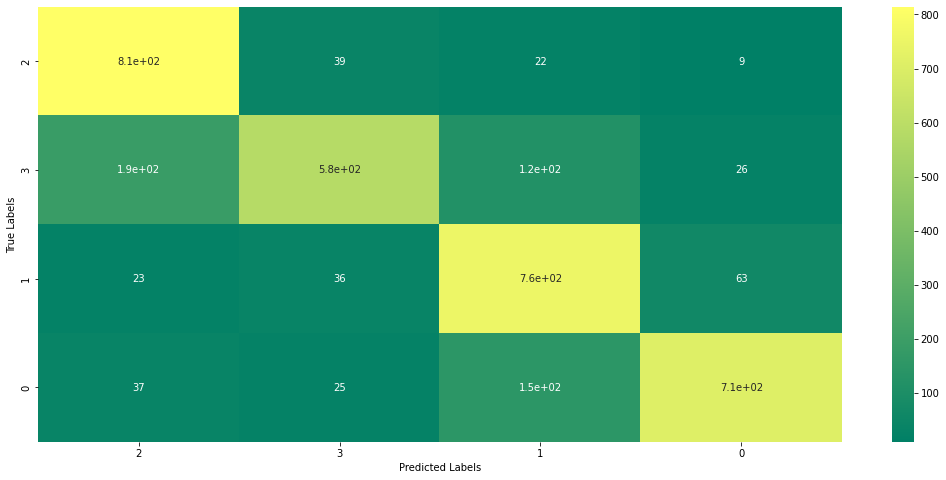

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
plt.figure(figsize = (18,8))
sns.heatmap(confusion_matrix(y_val, predictions), annot = True, xticklabels = df['product'].unique(), yticklabels = df['product'].unique(), cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

https://www.kaggle.com/nkitgupta/evaluation-metrics-for-multi-class-classification/notebook

## Random Forest Classifier (RFC)
Random Forest is a classifier that contains a number of decision trees on various subsets of the given dataset and takes the average to improve the predictive accuracy of that dataset.

In [55]:
from sklearn.ensemble import RandomForestClassifier

In [56]:
param_grid = { 
    'n_estimators': [700,800],
    'max_depth' : [7,8, 9, 10, 11]
 #   'criterion' :['gini', 'entropy']
}
rfc=RandomForestClassifier(random_state=42)

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [7, 8, 9, 10, 11],
                         'n_estimators': [700, 800]})

In [57]:
print(CV_rfc.best_score_)
print(CV_rfc.best_params_)

0.79
{'max_depth': 11, 'n_estimators': 800}


In [58]:
predictions = CV_rfc.best_estimator_.predict(X_val_tfidf)

Labels order: [2 3 1 0] 
F1 Score: [0.78337662 0.81922197 0.72738773 0.83761562]
Test Set Accuracy : 79.44444444444444 %


Classification Report : 

              precision    recall  f1-score   support

           0       0.77      0.92      0.84       884
           1       0.86      0.63      0.73       916
           2       0.72      0.86      0.78       879
           3       0.87      0.78      0.82       921

    accuracy                           0.79      3600
   macro avg       0.80      0.80      0.79      3600
weighted avg       0.81      0.79      0.79      3600



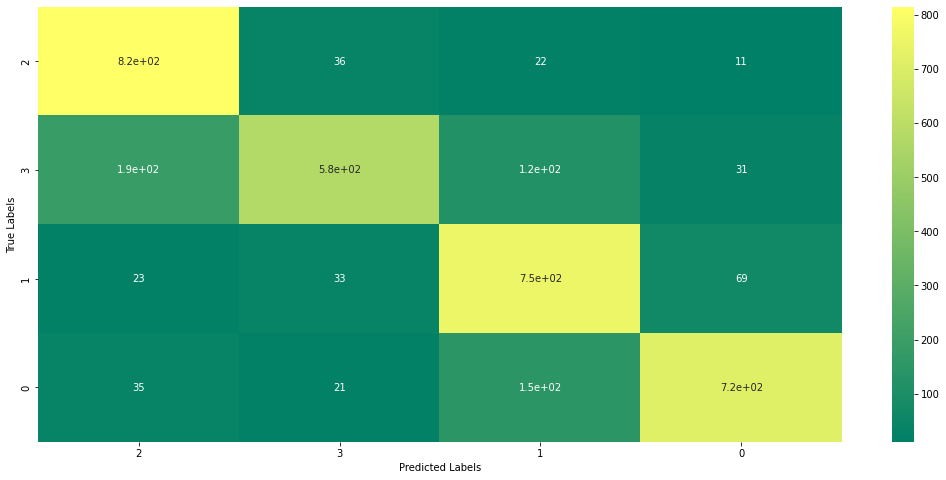

In [59]:
scores(predictions,y_val)

In [60]:
model_name.append('Random Forest Classifier')
f1.append(f1_score(y_val, predictions,average='weighted') * 100)
accuracy.append(accuracy_score(y_val, predictions) * 100)

In [61]:
a,b,c,d=f1_score(y_val, predictions,average=None)
f1_score_label_1.append(d)
f1_score_label_2.append(c) 
f1_score_label_3.append(b) 
f1_score_label_4.append(a)  

https://www.kaggle.com/nkitgupta/evaluation-metrics-for-multi-class-classification/notebook

## Logistic Regression (LR)
Logistic Regression is a predictive analysis algorithm based on the concept of probability.

In [62]:
from sklearn.linear_model import LogisticRegression

param_grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg = LogisticRegression(max_iter=500)

CV_lr = GridSearchCV(estimator=logreg, param_grid=param_grid, cv= 5)
CV_lr.fit(X_train_tfidf, y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solver

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=500),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']})

In [63]:
print(CV_lr.best_score_)
print(CV_lr.best_params_)

0.8239285714285713
{'C': 1000.0, 'penalty': 'l2'}


Labels order: [2 3 1 0] 
F1 Score: [0.81253497 0.84302964 0.79614949 0.87123288]
Test Set Accuracy : 83.11111111111111 %


Classification Report : 

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       884
           1       0.83      0.77      0.80       916
           2       0.80      0.83      0.81       879
           3       0.85      0.83      0.84       921

    accuracy                           0.83      3600
   macro avg       0.83      0.83      0.83      3600
weighted avg       0.83      0.83      0.83      3600



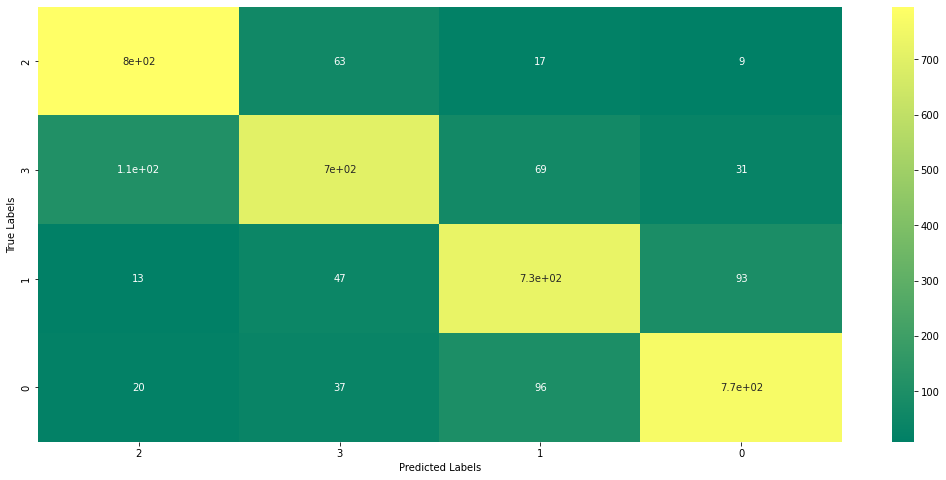

In [64]:
predictions = CV_lr.best_estimator_.predict(X_val_tfidf)

scores(predictions,y_val)

In [65]:
model_name.append('Logistic Regression')
f1.append(f1_score(y_val, predictions,average='weighted') * 100)
accuracy.append(accuracy_score(y_val, predictions) * 100)

In [66]:
a,b,c,d=f1_score(y_val, predictions,average=None)
f1_score_label_1.append(d)
f1_score_label_2.append(c) 
f1_score_label_3.append(b) 
f1_score_label_4.append(a)  

ROC score method

In [67]:
from sklearn.metrics import roc_auc_score

def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [68]:
roc_auc_dict = roc_auc_score_multiclass(y_val, predictions)
roc_auc_dict

{0: 0.922782872070319,
 1: 0.8563491237089921,
 2: 0.8795256963598757,
 3: 0.8921154157137247}

In [ ]:
from sklearn.naive_bayes import MultinomialNB

grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 10.0, 1e-1, 1e-2] 
}

cv_nb = GridSearchCV(estimator=MultinomialNB(), param_grid=grid, verbose=1, cv=10, n_jobs=-1)
cv_nb.fit(X_train_tfidf, y_train)


Fitting 10 folds for each of 7 candidates, totalling 70 fits


GridSearchCV(cv=10, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.5, 1.0, 10.0, 0.1, 0.01]},
             verbose=1)

In [ ]:
print(cv_nb.best_score_)
print(cv_nb.best_params_)

0.8115476190476191
{'alpha': 0.5}


In [ ]:
predictions_bayes = cv_nb.best_estimator_.predict(X_val_tfidf)

f1_score(y_val, predictions_bayes, average = None) 

array([0.87088061, 0.77625571, 0.79800222, 0.83899721])

In [ ]:
print(f"Test Set Accuracy : {accuracy_score(y_val, predictions_bayes) * 100} %\n\n")
print(f"Classification Report : \n\n{classification_report(y_val, predictions_bayes)}")

Test Set Accuracy : 82.16666666666667 %


Classification Report : 

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       884
           1       0.81      0.74      0.78       916
           2       0.78      0.82      0.80       879
           3       0.86      0.82      0.84       921

    accuracy                           0.82      3600
   macro avg       0.82      0.82      0.82      3600
weighted avg       0.82      0.82      0.82      3600



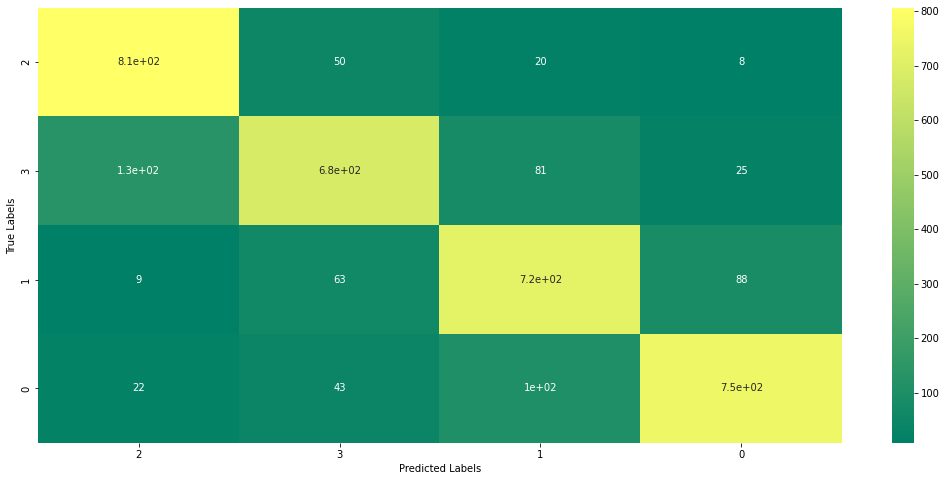

In [ ]:
plt.figure(figsize = (18,8))
sns.heatmap(confusion_matrix(y_val, predictions_bayes), annot = True, xticklabels = df['product'].unique(), yticklabels = df['product'].unique(), cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Naive Bayes
The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. 

In [69]:
from sklearn.naive_bayes import MultinomialNB

grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 10.0, 1e-1, 1e-2] 
}

cv_nb = GridSearchCV(estimator=MultinomialNB(), param_grid=grid, verbose=1, cv=10, n_jobs=-1)
cv_nb.fit(X_train_tfidf, y_train)


Fitting 10 folds for each of 7 candidates, totalling 70 fits


GridSearchCV(cv=10, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.5, 1.0, 10.0, 0.1, 0.01]},
             verbose=1)

In [71]:
print(cv_nb.best_score_)
print(cv_nb.best_params_)

0.8115476190476191
{'alpha': 0.5}


Labels order: [2 3 1 0] 
F1 Score: [0.79800222 0.83899721 0.77625571 0.87088061]
Test Set Accuracy : 82.16666666666667 %


Classification Report : 

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       884
           1       0.81      0.74      0.78       916
           2       0.78      0.82      0.80       879
           3       0.86      0.82      0.84       921

    accuracy                           0.82      3600
   macro avg       0.82      0.82      0.82      3600
weighted avg       0.82      0.82      0.82      3600



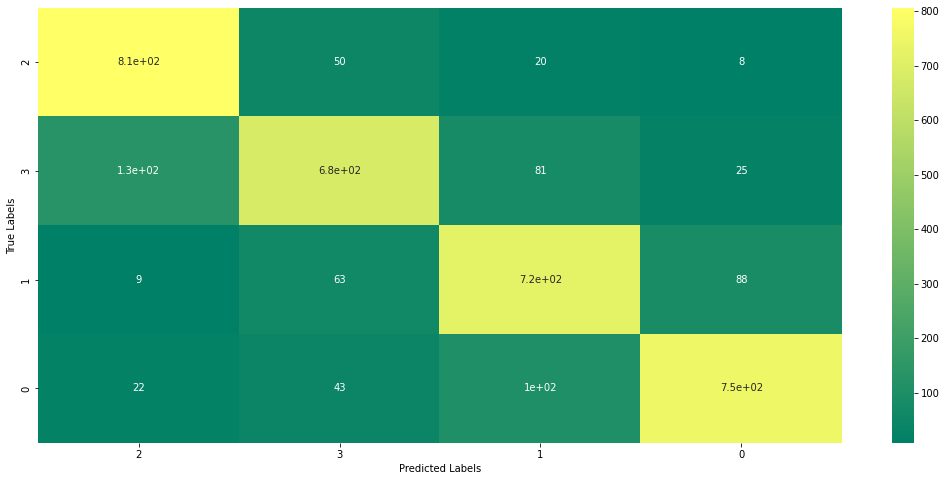

In [72]:
predictions = cv_nb.best_estimator_.predict(X_val_tfidf)

scores(predictions,y_val)

In [73]:
model_name.append('Naive Bayes')
f1.append(f1_score(y_val, predictions,average='weighted') * 100)
accuracy.append(accuracy_score(y_val, predictions) * 100)
a,b,c,d=f1_score(y_val, predictions,average=None)
f1_score_label_1.append(d)
f1_score_label_2.append(c) 
f1_score_label_3.append(b) 
f1_score_label_4.append(a)  

###Transformer

In [ ]:
print('Original: ', X[0])
print('Processed: ', text_preprocessing(X[0]))

Original:  lo descartó
Processed:  descartó


In [ ]:
import torch
from transformers import BertForMaskedLM, BertTokenizer, BertForNextSentencePrediction
#BETO
tokenizer = BertTokenizer.from_pretrained("pytorch/", do_lower_case=False)

In [ ]:
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
# Concatenate train data and test data
all_tweets = np.concatenate([X_train, X_val])

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  158


In [ ]:
# Specify `MAX_LEN`
MAX_LEN = max_len

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X_train[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  lo descartó
Token IDs:  [4, 1678, 6067, 22820, 5037, 1084, 14295, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Tokenizing data...


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train) 
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 4

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('pytorch/')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 347 µs, sys: 0 ns, total: 347 µs
Wall time: 355 µs


In [ ]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()


def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)
           
            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t  for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)

Some weights of the model checkpoint at pytorch/ were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future v

In [ ]:
train(bert_classifier, train_dataloader, val_dataloader, epochs=4, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


KeyboardInterrupt: ignored

In [ ]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

In [ ]:
X_test[:10]

array(['Fui a ayudar a mi hija a conseguir un apartamento mientras estaba allí. La gerencia me informó que no podía conseguirle un apartamento a mi nombre debido a que no tenía buen crédito. Después de que me fui, decidí sacar mi crédito para ver de qué estaba hablando la señora de la gerencia y me sorprendió el resultado de mi informe. hay muchos artículos ahí que no me pertenecen. elimine estos elementos de mi informe.',
       'esta es la segunda vez que notifico a las agencias de crédito sobre mi problema con el robo de identidad. Yo no abrí las cuentas incluidas en esta disputa y deben eliminarse de mis informes crediticios de inmediato.\n\nNo entiendo cómo siguen denunciando estas cuentas después de haberles notificado el problema.\n\nTambién soy víctima de la violación de datos de Equifax, por lo que mi información podría estar en manos de otras personas.\n\nelimine estas cuentas de inmediato.',
       'solicité una tarjeta de crédito {$300.00} se tomaron de mi cuenta corriente 

In [ ]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(X_test)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)
print(probs)


[[0.01335781 0.02847551 0.8469054  0.11126125]
 [0.01239385 0.02803835 0.8703399  0.08922794]
 [0.1228723  0.14057513 0.09439067 0.6421619 ]
 ...
 [0.02134713 0.03630601 0.7583543  0.18399252]
 [0.0664004  0.07979831 0.18243232 0.67136896]
 [0.0144328  0.02995415 0.8375117  0.11810137]]


In [ ]:
test = probs[:,None].argmax(-1)
test

In [ ]:
f1_score(y_test, test, average = None) 

array([0.        , 0.        , 0.80161943, 0.67431193])

In [ ]:
X_test.flatten()

In [ ]:
#2310
df['product_str'].unique()

str_label = []
for i in test.flatten():
  if i == 2:
    str_label.append(df['product_str'].unique()[0])
  elif i == 3:
    str_label.append(df['product_str'].unique()[1])
  elif i == 1:
    str_label.append(df['product_str'].unique()[2])
  else:
    str_label.append(df['product_str'].unique()[3])
df_results = pd.DataFrame({'True Label':y_test.flatten(),'Predicted Label':test.flatten(), 'Predicted Label str':str_label, 'Narrative': X_test.flatten()})
   

In [ ]:
df_results = pd.DataFrame({'True Label':y_test.flatten(),'Predicted Label':test.flatten(), 'Predicted Label str':str_label, 'Narrative': X_test.flatten()})
df_results

,True Label,Predicted Label,Predicted Label str,Narrative
0,2,2,"Credit reporting, credit repair services, or o...",Fui a ayudar a mi hija a conseguir un apartame...
1,2,2,"Credit reporting, credit repair services, or o...",esta es la segunda vez que notifico a las agen...
2,1,3,Debt collection,solicité una tarjeta de crédito {$300.00} se t...
3,2,2,"Credit reporting, credit repair services, or o...",No puedo iniciar sesión en mi cuenta de Equifa...
4,2,2,"Credit reporting, credit repair services, or o...","He tenido tantos problemas con esta empresa, d..."
...,...,...,...,...
495,1,3,Debt collection,recibí 2 tarjetas de crédito de nosotros bankr...
496,3,3,Debt collection,numerosas llamadas telefónicas acosándome por ...
497,2,2,"Credit reporting, credit repair services, or o...",estas no son mis cuentas. por favor elimínelos...
498,2,3,Debt collection,el departamento de educación de los estados un...


# Results

In this section we compare the scores between models.

In [74]:
import pandas as pd
  
df_results = pd.DataFrame({'Model':model_name, 'F1-score':f1, 'Accuracy':accuracy, 'F1-label_1':f1_score_label_1, 'F1-label_2':f1_score_label_2,'F1-label_3':f1_score_label_3,'F1-label_4':f1_score_label_4})
df_results.sort_values(by='F1-score',ascending=False)

,Model,F1-score,Accuracy,F1-label_1,F1-label_2,F1-label_3,F1-label_4
2,Logistic Regression,83.058093,83.111111,0.843030,0.812535,0.796149,0.871233
0,Support Vector Machine,82.965447,83.055556,0.845179,0.821229,0.789383,0.863588
3,Naive Bayes,82.085252,82.166667,0.838997,0.798002,0.776256,0.870881
1,Random Forest Classifier,79.161968,79.444444,0.819222,0.783377,0.727388,0.837616
